In [1]:
from lib.HK.header_notebook import *
import lib.HK.OTCommon as OTCommon
import lib.HK.SinkhornNP as Sinkhorn
import lib.HK.LinHK as LinHK
import lib.HK.LinW2 as LinW2
import lib.HK.Tools as Tools
from scipy import sparse


import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot


import torch


os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
from lib.lib_lopt import *
from lib.geodesic import *
#from lib.lib_shape import *
%matplotlib inline

# Comparison between HK and OPT interporlation 
## Test it in a simple Diarec measure. 

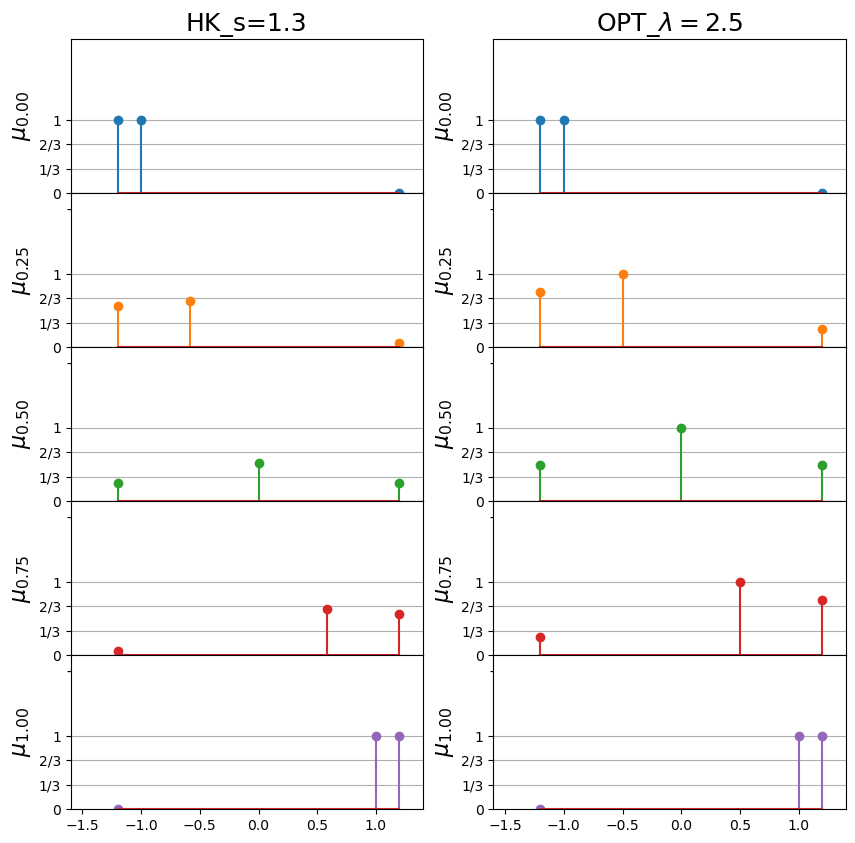

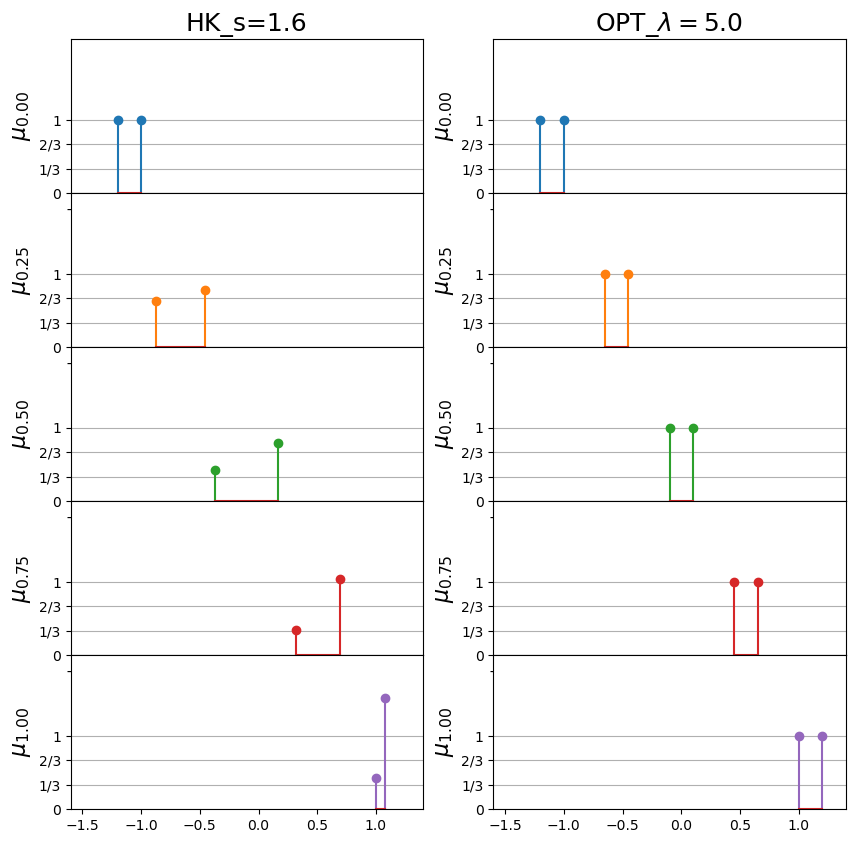

In [3]:

setup_HKScale_list=[1.3,1.6]
Lambda_list=[2.5,5.0]

posmu = np.array([[-1.2],[-1]])
mu = np.array([1,1])
posNu = np.array([[1],[1.2]])
nu = np.array([1, 1])
K=5
for setup_HKScale,Lambda in zip(setup_HKScale_list,Lambda_list):
    
    
    # HK start 
    tList=np.linspace(0,1,K)
    fig,ax=plt.subplots(K,2,figsize=(10,10))
    # solve HK 
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1.E-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1E3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

    # solve HK transport
    value,pi=Sinkhorn.SolveHK(mu,posmu,nu,posNu,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False
            )

    # from optimal coupling compute tangent vector data
    u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(pi,mu,nu,posNu)
    v0,alpha0=LinHK.HKLog(posmu,u0,x1,u1,params["setup_HKScale"])
    
    # HK end 
    
    # Solve OPT
    u0_opt,p0_opt,M_opt,nuPerp=lopt_embedding(posmu,posNu,mu,nu,Lambda)
    #u1_opt,p1_opt,M1_opt=lopt_embedding(posNu,posmu,nu,mu,Lambda)
    
    Xt_list,pt,X_d,p_d=opt_interpolation(posmu,u0_opt,mu,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
    X_c=posNu[nuPerp>0]
    p_c=nuPerp[nuPerp>0]
    #p_c=opt_interpolation(posNu,u1_opt,nu,p1_opt,np.array([0.]))
    

    for j in range(2):
        for i,t in enumerate(tList):
            # shoot averaged tangent vector back to a measure
            s='C%d-'%i
            if j==0:
                # HK start 
                expmu,expT=LinHK.HKExp(mu,posmu,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
                expT=np.concatenate([expT,posNu[nuPerp>0]]) 
                expmu=np.concatenate([expmu,nuPerp[nuPerp>0]*t**2])
                # HK end 
               # result['HK-'+str(setup_HKScale)].append((expT,expmu))   
                if i==0: 
                    ax[i,j].set_title('HK_s='+str(setup_HKScale),fontsize=18)
                
            else:
                expT=np.concatenate([Xt_list[i],X_d,X_c])
                expmu=np.concatenate([pt,(1-t)*p_d,t*p_c])
                #result['OPT-'+str(Lambda)].append((expT,expmu))
                if i==0:
                    ax[i,j].set_title('OPT_$\lambda=$'+str(Lambda),fontsize=18)
  

            ax[i,j].stem(expT,expmu,s)
            ax[i,j].set_xlim([-1.6,1.4])
            ax[i,j].set_ylim([0,2.1])
            ax[i,j].set_ylabel(r'$\mu_{%0.2f}$'%t,fontsize=16)
            ax[i,j].grid(True,axis='y')
            ax[i,j].set_yticks([0,1/3,2/3,1])
            ax[i,j].set_yticklabels(['0','1/3','2/3','1'])
            # if i not in [0,4]:
            #     ax[i,j].tick_params(left = False, right = False , labelleft = False ,
            #         labelbottom = False, bottom = False)
        plt.subplots_adjust( hspace=0)
    #plt.savefig('experiment/Fig1/comparisonHK_%0.2f.pdf'%(params["setup_HKScale"]),bbox_inches='tight')
#torch.save(result,'experiment/Fig1/result_1d.pt')

# Comparison between HK and OPT interporlation in 2D dirac measures

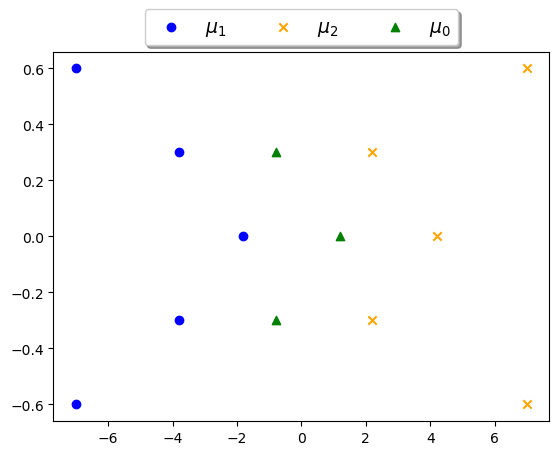

In [5]:
Tri=np.array(
[[-0.8,0.3],
[-0.8,-0.3],
[1.2,0]],dtype=np.float64)
Noise=np.array(
[[-4,0.6],
[-4,-0.6]],dtype=np.float64)

X0=Tri
mu0=np.ones(3)

X1=np.concatenate((Tri,Noise))
X1[:,0]-=3
mu1=np.ones(5)

X2=np.concatenate((Tri,Noise))
X2[:,0]+=3
X2[3:5,0]+=8

mu2=np.ones(5)

plt.scatter(X1[:,0],X1[:,1],c='blue',marker='o',label='$\mu_1$')
plt.scatter(X2[:,0],X2[:,1],c='orange',marker='x',label='$\mu_2$')
plt.scatter(X0[:,0],X0[:,1],c='green',marker='^',label='$\mu_0$')
#plt.scatter(X2[:,0],X2[:,1],c='orange',marker='x')
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.14),
          fancybox=True, shadow=True, ncol=3,fontsize=13.6)
plt.savefig('experiment/Rebuttal/triangle_data.png',bbox_inches='tight')

plt.show()

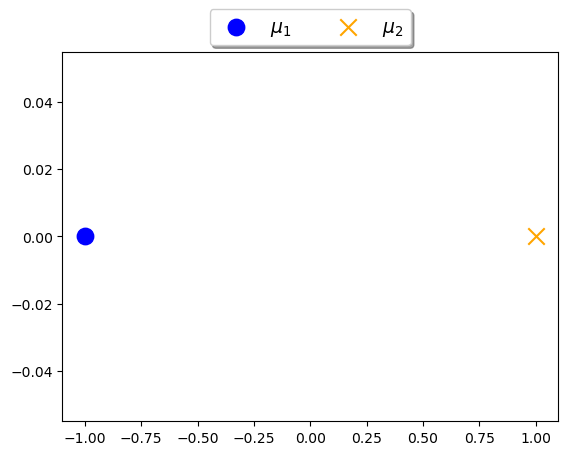

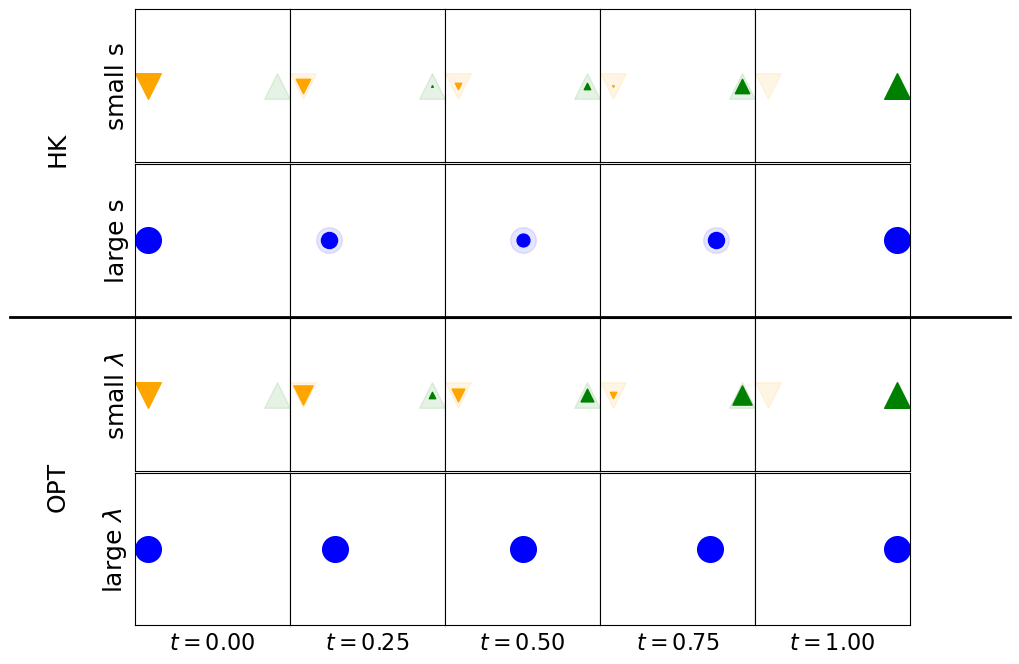

In [13]:
X1=np.array([[-1,0]],dtype=np.float64)
mu1=np.array([1.0])
X2=np.array([[1,0]],dtype=np.float64)
mu2=np.array([1.0])


plt.scatter(X1[:,0],X1[:,1],c='blue',marker='o',label='$\mu_1$',s=140)
plt.scatter(X2[:,0],X2[:,1],c='orange',marker='x',label='$\mu_2$',s=140)

plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.14),
          fancybox=True, shadow=True, ncol=3,fontsize=13.6)
plt.savefig('experiment/Rebuttal/A1_data.png',bbox_inches='tight')

plt.show()




#setup_HKScale=np.sqrt(2*Lambda)*2/np.pi

K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(4,K,figsize=(10,8))

setup_HKScale_list=[0.2, 1.2749]
Lambda_list=[0.5, 4.0]
key_list=['small','large']
K0=len(setup_HKScale_list)
# # Solve OPT
# u0_opt,p0_opt,M_opt,nuPerp_opt=lopt_embedding(X1,X2,p1,p2,Lambda)
# Xt_list,pt,X_d,p_d=opt_interpolation(X1,u0_opt,p1,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
# X_c=X2[nuPerp_opt>0]
# p_c=nuPerp_opt[nuPerp_opt>0]



for (setup_HKScale,key,i) in zip(setup_HKScale_list,key_list,range(K0)):
    # Do HK interporlation
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1e-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1e3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

    value,gamma=Sinkhorn.SolveHK(mu1,X1,mu2,X2,HKScale=params["setup_HKScale"],
    SinkhornError=params["solver_errorGoal"],
    epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
    returnSolver=False
    )
    u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(gamma,mu1,mu2,X2)
    v0,alpha0=LinHK.HKLog(X1,u0,x1,u1,params["setup_HKScale"])
        
    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        mu_a,X_a=LinHK.HKExp(mu1,X1,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
        D=np.sum(v0**2,1)>1e-10
        mu_t=mu_a[D]
        mu_d=mu_a[np.invert(D)]
        X_t=X_a[D]
        X_d=X_a[np.invert(D)]
        X_c=X2[nuPerp>0]
        mu_c=nuPerp[nuPerp>0]*t**2
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*340,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*340,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*340,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*340,color='orange',marker='v',alpha=0.1)
        if mu_c.shape[0]>0:
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*340,color='green',marker='^')
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*340,color='green',marker='^',alpha=0.1)
        ax[i,j].set_xlim([-1.2,1.2])
        ax[i,j].set_ylim([-0.01,0.01])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' s',rotation=90,fontsize=18)
        # add text to left side of figure

    


for (Lambda,key,i) in zip(Lambda_list,key_list,range(K0,2*K0)):
    u0_opt,p0_opt,M_opt,nuPerp_opt=lopt_embedding(X1,X2,mu1,mu2,Lambda)
    Xt_list,mu_t,X_d,p_d=opt_interpolation(X1,u0_opt,mu1,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
    X_c=X2[nuPerp_opt>0]
    p_c=nuPerp_opt[nuPerp_opt>0]
    for j,t in enumerate(tList):
        X_t=Xt_list[j]
        mu_d=p_d*(1-t)
        mu_c=p_c*t
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*340,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*340,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*340,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*340,color='orange',marker='v',alpha=0.1)
        if mu_c.shape[0]>0:
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*340,color='green',marker='^')
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*340,color='green',marker='^',alpha=0.1)
        
        ax[i,j].set_xlim([-1.2,1.2])
        ax[i,j].set_ylim([-0.01,0.01])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' $\lambda$',rotation=90,fontsize=18)
        if i==2*K0-1:
            ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)
ax[K0-1, 0].text(-0.5, 1.1, "HK", rotation=90, fontsize=18, va="center", ha="center", transform=ax[K0-1, 0].transAxes)
ax[K0, 0].text(-0.5, -0.1, "OPT",rotation=90, fontsize=18, va="center", ha="center", transform=ax[K0, 0].transAxes)


fig.add_artist(plt.Line2D((0, 1), (0.495,0.495), color='black', linewidth=2, transform=fig.transFigure))
plt.subplots_adjust(wspace=0, hspace=0.01)
plt.savefig('experiment/Rebuttal/Dirac.HK_OPT.png',bbox_inches='tight')

plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')


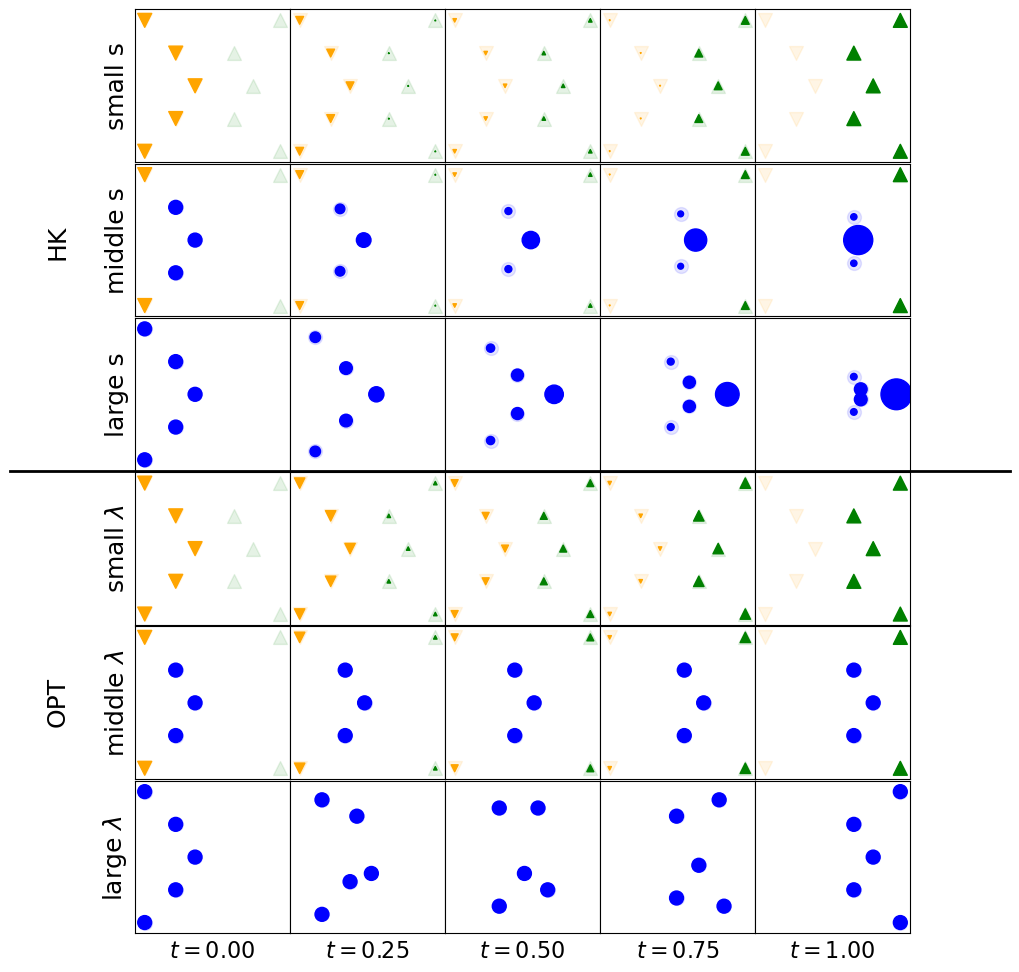

In [16]:
setup_HKScale_list=np.array([1.2, 5.2, 10.6])
Lambda_list=np.array([0.5, 30.0 , 100.0])
K0=setup_HKScale_list.shape[0]
key_list=['small','middle','large']

K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(2*K0,K,figsize=(2*K,K0*2*2))

scaling=100


for (setup_HKScale,key,i) in zip(setup_HKScale_list,key_list,range(K0)):
    # Do HK interporlation
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1e-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1e3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

    value,gamma=Sinkhorn.SolveHK(mu1,X1,mu2,X2,HKScale=params["setup_HKScale"],
    SinkhornError=params["solver_errorGoal"],
    epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
    returnSolver=False
    )
    u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(gamma,mu1,mu2,X2)
    v0,alpha0=LinHK.HKLog(X1,u0,x1,u1,params["setup_HKScale"])
        
    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        mu_a,X_a=LinHK.HKExp(mu1,X1,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
        D=np.sum(v0**2,1)>1e-10
        mu_t=mu_a[D]
        mu_d=mu_a[np.invert(D)]
        X_t=X_a[D]
        X_d=X_a[np.invert(D)]
        X_c=X2[nuPerp>0]
        mu_c=nuPerp[nuPerp>0]*t**2
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
        if mu_c.shape[0]>0:
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
        ax[i,j].set_xlim([-8,8])
        ax[i,j].set_ylim([-0.7,0.7])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' s',rotation=90,fontsize=18)
        # add text to left side of figure

    


for (Lambda,key,i) in zip(Lambda_list,key_list,range(K0,2*K0)):
    u0_opt,p0_opt,M_opt,nuPerp_opt=lopt_embedding(X1,X2,mu1,mu2,Lambda)
    Xt_list,mu_t,X_d,p_d=opt_interpolation(X1,u0_opt,mu1,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
    X_c=X2[nuPerp_opt>0]
    p_c=nuPerp_opt[nuPerp_opt>0]
    for j,t in enumerate(tList):
        X_t=Xt_list[j]
        mu_d=p_d*(1-t)
        mu_c=p_c*t
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
        if mu_c.shape[0]>0:
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
        
        ax[i,j].set_xlim([-8,8])
        ax[i,j].set_ylim([-0.7,0.7])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' $\lambda$',rotation=90,fontsize=18)
        if i==2*K0-1:
            ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)
ax[K0-1, 0].text(-0.5,1.5, "HK", rotation=90, fontsize=18, va="center", ha="center", transform=ax[K0-1, 0].transAxes)
ax[K0, 0].text(-0.5,-0.5, "OPT",rotation=90, fontsize=18, va="center", ha="center", transform=ax[K0, 0].transAxes)

fig.add_artist(plt.Line2D((0, 1), (0.495,0.495), color='black', linewidth=2, transform=fig.transFigure))
plt.subplots_adjust(wspace=0, hspace=0.01)
plt.savefig('experiment/Rebuttal/triangle.HK_OPT.png',bbox_inches='tight')

plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')


# Comparison between LHK and LOPT in 2D toy example

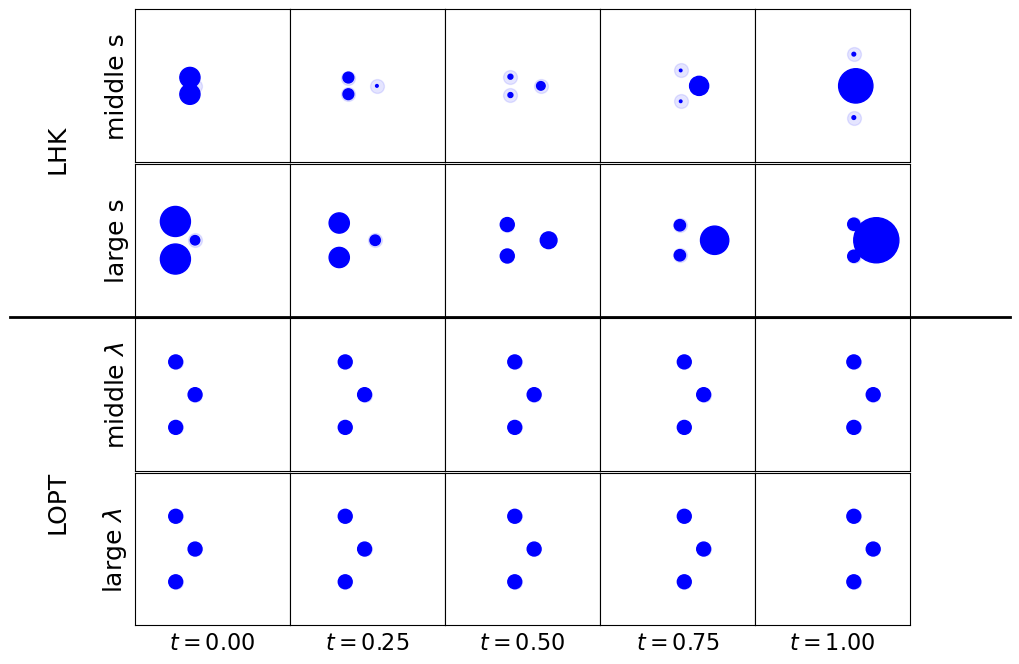

In [6]:
setup_HKScale_list=np.array([2.5, 5.0])
Lambda_list=np.array([20, 80])
K0=setup_HKScale_list.shape[0]
key_list=['middle','large']

K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(2*K0,K,figsize=(2*K,K0*2*2))

scaling=100
for (setup_HKScale,key,i) in zip(setup_HKScale_list,key_list,range(K0)):
    # Do HK interporlation
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1e-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1e3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 
    
    value,gamma=Sinkhorn.SolveHK(mu0,X0,mu1,X1,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False)
        

    # from optimal coupling compute tangent vector data
    u0_1,u1_1,x1_1,muPerp_1,nuPerp_1=LinHK.extractMongeData(gamma,mu0,mu1,X1)
    v0_1,alpha0_1=LinHK.HKLog(X0,u0_1,x1_1,u1_1,params["setup_HKScale"])
    
    
    value,gamma=Sinkhorn.SolveHK(mu0,X0,mu2,X2,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False
            )

    u0_2,u1_2,x1_2,muPerp_2,nuPerp_2=LinHK.extractMongeData(gamma,mu0,mu2,X2)
    v0_2,alpha0_2=LinHK.HKLog(X0,u0_2,x1_2,u1_2,params["setup_HKScale"])

       
        
    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        v0_t=(1-t)*v0_1+t*v0_2
        alpha0_t=(1-t)*alpha0_1+t*alpha0_2
        mu_a,X_a=LinHK.HKExp(mu0,X0,v0_t,alpha0_t,HKScale=params["setup_HKScale"])
        D=np.sum(v0_t**2,1)>1e-10
        mu_t=mu_a[D]
        mu_d=mu_a[np.invert(D)]
        X_t=X_a[D]
        X_d=X_a[np.invert(D)]
        #X_c=X2[nuPerp>0]
        #mu_c=nuPerp[nuPerp>0]*t**2
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0 and np.sum(mu_d)>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
        #if mu_c.shape[0]>0:
        #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
        #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
        ax[i,j].set_xlim([-8,8])
        ax[i,j].set_ylim([-0.7,0.7])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' s',rotation=90,fontsize=18)
        # add text to left side of figure

    


for (Lambda,key,i) in zip(Lambda_list,key_list,range(K0,2*K0)):
    u1_opt,p1_hat,M1,p1_perp=lopt_embedding(X0,X1,mu0,mu1,Lambda)
    u2_opt,p2_hat,M2,p2_perp=lopt_embedding(X0,X2,mu0,mu2,Lambda)
    Xt_list,mu_t,X_d,p_d,X_c,p_c=lopt_interpolation(X0,u1_opt,u2_opt,p1_hat,p2_hat,tList)   # (X0,U1,p0,p1_hat,t_list)

    for j,t in enumerate(tList):
        X_t=Xt_list[j]
        mu_d=p_d*(1-t)
        mu_c=p_c*t
        if mu_t.shape[0]>0:
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
            ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
        if mu_d.shape[0]>0 and np.sum(mu_d)>0:
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
            ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
        if mu_c.shape[0]>0 and np.sum(mu_c)>0:
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
            ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
        
        ax[i,j].set_xlim([-8,8])
        ax[i,j].set_ylim([-0.7,0.7])
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        if j==0:
            ax[i,j].set_ylabel(key+' $\lambda$',rotation=90,fontsize=18)
        if i==2*K0-1:
            ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)
ax[K0-1, 0].text(-0.5, 1.1, "LHK", rotation=90, fontsize=18, va="center", ha="center", transform=ax[K0-1, 0].transAxes)
ax[K0, 0].text(-0.5,-0.2, "LOPT",rotation=90, fontsize=18, va="center", ha="center", transform=ax[K0, 0].transAxes)

fig.add_artist(plt.Line2D((0, 1), (0.495,0.495), color='black', linewidth=2, transform=fig.transFigure))
plt.subplots_adjust(wspace=0, hspace=0.01)
plt.savefig('experiment/Rebuttal/triangle.LHK_LOPT_v2.png',bbox_inches='tight')

plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')


# Experiment: test the interporlation in 2D MNIST point cloud data

# Plot the barycenter 


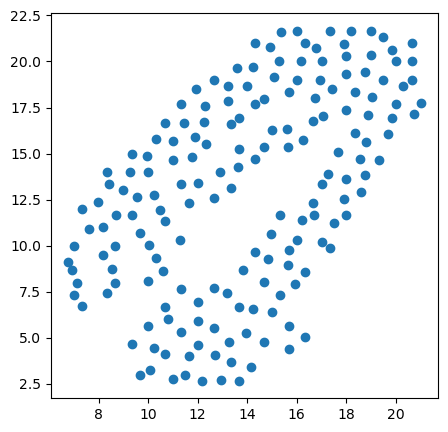

In [10]:
MNIST_data=torch.load('experiment/data/MNIST/geodesic1.pt')
data_list=MNIST_data['0']


Xi_list=list()
pi_list=list()
weights=np.ones(3)/3
N_list=np.zeros(3,dtype=np.int64)
for (i,data) in enumerate(data_list):
    Xi_list.append(data[:,0:2])
    pi_list.append(data[:,3])
    N_list[i]=data[:,0:2].shape[0]
N0=N_list.max()
p0=np.ones(N0)/N0

X0_init=data_list[0][:,0:2]
X1=Xi_list[0]
p1=pi_list[0]
#lot_embedding(X0, X1, p0, p1)
Lambda=50.0
X0=lopt_barycenter(Xi_list,pi_list,X0_init,p0,weights,Lambda,numItermax=2000000,stopThr=1e-7)

fig,ax=plt.subplots(1,1,figsize=(5,5))
plt.scatter(X0[:,0],X0[:,1])
plt.show()

# Plot the dataset 

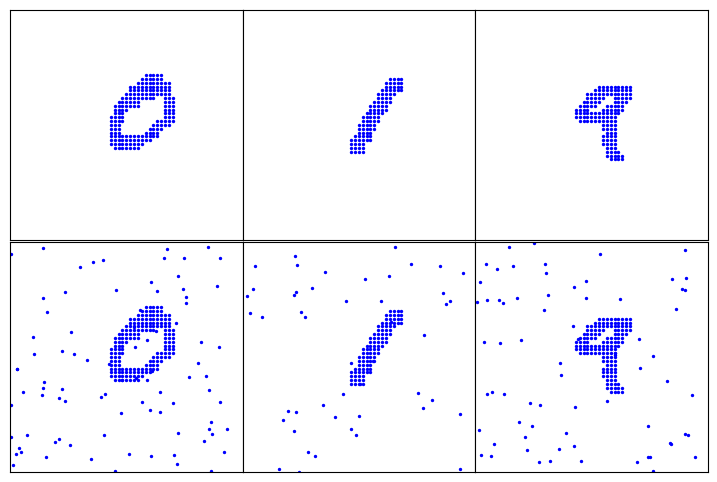

In [11]:
fig,ax=plt.subplots(2,3,figsize=(3*3,2*3))
for (i,per) in enumerate([0,0.5]):
    data_list=MNIST_data[str(per)]
    for j in range(3):
        data=data_list[j]
        X=data[:,0:2]
        p=data[:,3]
        ax[i,j].scatter(X[:,0],X[:,1],s=2,c='blue')
        ax[i,j].set_xlim(-20,40)
        ax[i,j].set_ylim(-20,40)
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0.01)
plt.savefig('experiment/Rebuttal/digit_data.png',bbox_inches='tight',dpi=200)

In [12]:
MNIST_data=torch.load('experiment/data/MNIST/geodesic1.pt')
data_list=MNIST_data['0.5']

Xi_list=list()
pi_list=list()
weights=np.ones(3)/3
N_list=np.zeros(3,dtype=np.int64)
for (i,data) in enumerate(data_list):
    Xi_list.append(data[:,0:2])
    pi_list.append(data[:,3])
    N_list[i]=data[:,0:2].shape[0]

# Interporlation with weighted mass

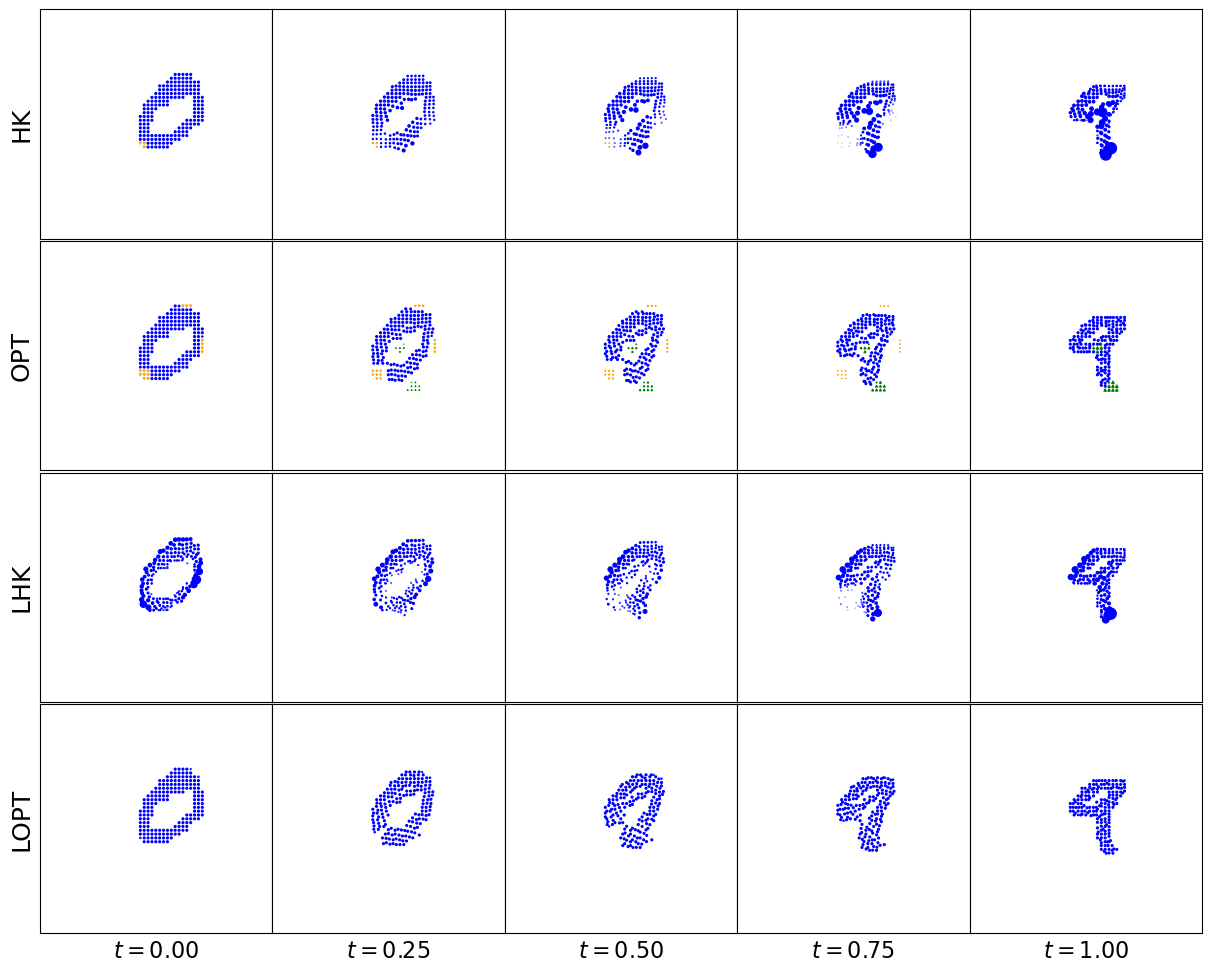

In [28]:

# Xi_list[0] is digit 0, xi_list[1] is digit 1, xi_list[2] is digit 9 

X1=Xi_list[0]
X2=Xi_list[2] # 
mu1=pi_list[0]
mu2=pi_list[2]
mu0=p0

K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(4,K,figsize=(3*5,3*4))
scaling=50000
i=0  # Do HK interporlation

setup_HKScale=3.5
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=setup_HKScale
params["solver_errorGoal"]=1e-4
params["aux_verbose"]=False
params["solver_epsStart"]=1e3*setup_HKScale/1.3 
params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

value,gamma=Sinkhorn.SolveHK(mu1,X1,mu2,X2,HKScale=params["setup_HKScale"],
SinkhornError=params["solver_errorGoal"],
epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
returnSolver=False
)
u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(gamma,mu1,mu2,X2)
v0,alpha0=LinHK.HKLog(X1,u0,x1,u1,params["setup_HKScale"])
        
for j,t in enumerate(tList):
    # shoot averaged tangent vector back to a measure
    mu_a,X_a=LinHK.HKExp(mu1,X1,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
    D=np.sum(v0**2,1)>1e-10
    mu_t=mu_a[D]
    mu_d=mu_a[np.invert(D)]
    X_t=X_a[D]
    X_d=X_a[np.invert(D)]
    X_c=X2[nuPerp>0]
    mu_c=nuPerp[nuPerp>0]*t**2
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
        #ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    if mu_c.shape[0]>0:
        ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
        #ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('HK',rotation=90,fontsize=18)

    
i=1 # Do OPT interporlation
Lambda=20.0
u0_opt,p0_opt,M_opt,nuPerp_opt=lopt_embedding(X1,X2,mu1,mu2,Lambda)
Xt_list,mu_t,X_d,p_d=opt_interpolation(X1,u0_opt,mu1,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
X_c=X2[nuPerp_opt>0]
p_c=nuPerp_opt[nuPerp_opt>0]
for j,t in enumerate(tList):
    X_t=Xt_list[j]
    mu_d=p_d*(1-t)
    mu_c=p_c*t
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
       # ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    if mu_c.shape[0]>0:
        ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
       # ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)

    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('OPT',rotation=90,fontsize=18)

i=2 # Do LHK interpolation 
setup_HKScale=2.5
                           
# Do HK interporlation
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=setup_HKScale
params["solver_errorGoal"]=1e-4
params["aux_verbose"]=False
params["solver_epsStart"]=1e3*setup_HKScale/1.3 
params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

value,gamma=Sinkhorn.SolveHK(mu0,X0,mu1,X1,HKScale=params["setup_HKScale"],
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False)

# from optimal coupling compute tangent vector data
u0_1,u1_1,x1_1,muPerp_1,nuPerp_1=LinHK.extractMongeData(gamma,mu0,mu1,X1)
v0_1,alpha0_1=LinHK.HKLog(X0,u0_1,x1_1,u1_1,params["setup_HKScale"])
    
    
value,gamma=Sinkhorn.SolveHK(mu0,X0,mu2,X2,HKScale=params["setup_HKScale"],
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False
        )
u0_2,u1_2,x1_2,muPerp_2,nuPerp_2=LinHK.extractMongeData(gamma,mu0,mu2,X2)
v0_2,alpha0_2=LinHK.HKLog(X0,u0_2,x1_2,u1_2,params["setup_HKScale"])

for j,t in enumerate(tList):
    # shoot averaged tangent vector back to a measure
    v0_t=(1-t)*v0_1+t*v0_2
    alpha0_t=(1-t)*alpha0_1+t*alpha0_2
    mu_a,X_a=LinHK.HKExp(p0,X0,v0_t,alpha0_t,HKScale=params["setup_HKScale"])
    D=np.sum(v0_t**2,1)>1e-10
    mu_t=mu_a[D]
    mu_d=mu_a[np.invert(D)]
    X_t=X_a[D]
    X_d=X_a[np.invert(D)]
    #X_c=X2[nuPerp>0]
    #mu_c=nuPerp[nuPerp>0]*t**2
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
        #ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0 and np.sum(mu_d)>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    # if mu_c.shape[0]>0:
    #     ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
    #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('LHK',rotation=90,fontsize=18)


i=3 # Do LOPT interpolation 
Lambda=25.0
u1_opt,p1_hat,M1,p1_perp=lopt_embedding(X0,X1,mu0,mu1,Lambda)
u2_opt,p2_hat,M2,p2_perp=lopt_embedding(X0,X2,mu0,mu2,Lambda)
Xt_list,mu_t,X_d,p_d,X_c,p_c=lopt_interpolation(X0,u1_opt,u2_opt,p1_hat,p2_hat,tList)   # (X0,U1,p0,p1_hat,t_list)

for j,t in enumerate(tList):
    X_t=Xt_list[j]
    mu_d=p_d*(1-t)
    mu_c=p_c*t
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=mu_t**2*scaling,color='blue',marker='o')
        #ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0 and np.sum(mu_d)>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    if mu_c.shape[0]>0 and np.sum(mu_c)>0:
        ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
        #ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)

    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('LOPT',rotation=90,fontsize=18)
                           
    
    ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)


#fig.add_artist(plt.Line2D((0, 1), (0.495,0.495), color='black', linewidth=2, transform=fig.transFigure))
plt.subplots_adjust(wspace=0, hspace=0.01)
#plt.savefig('experiment/Rebuttal/'+label+'.png',bbox_inches='tight')

plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')


In [ ]:
# Interporlation with uniform mass

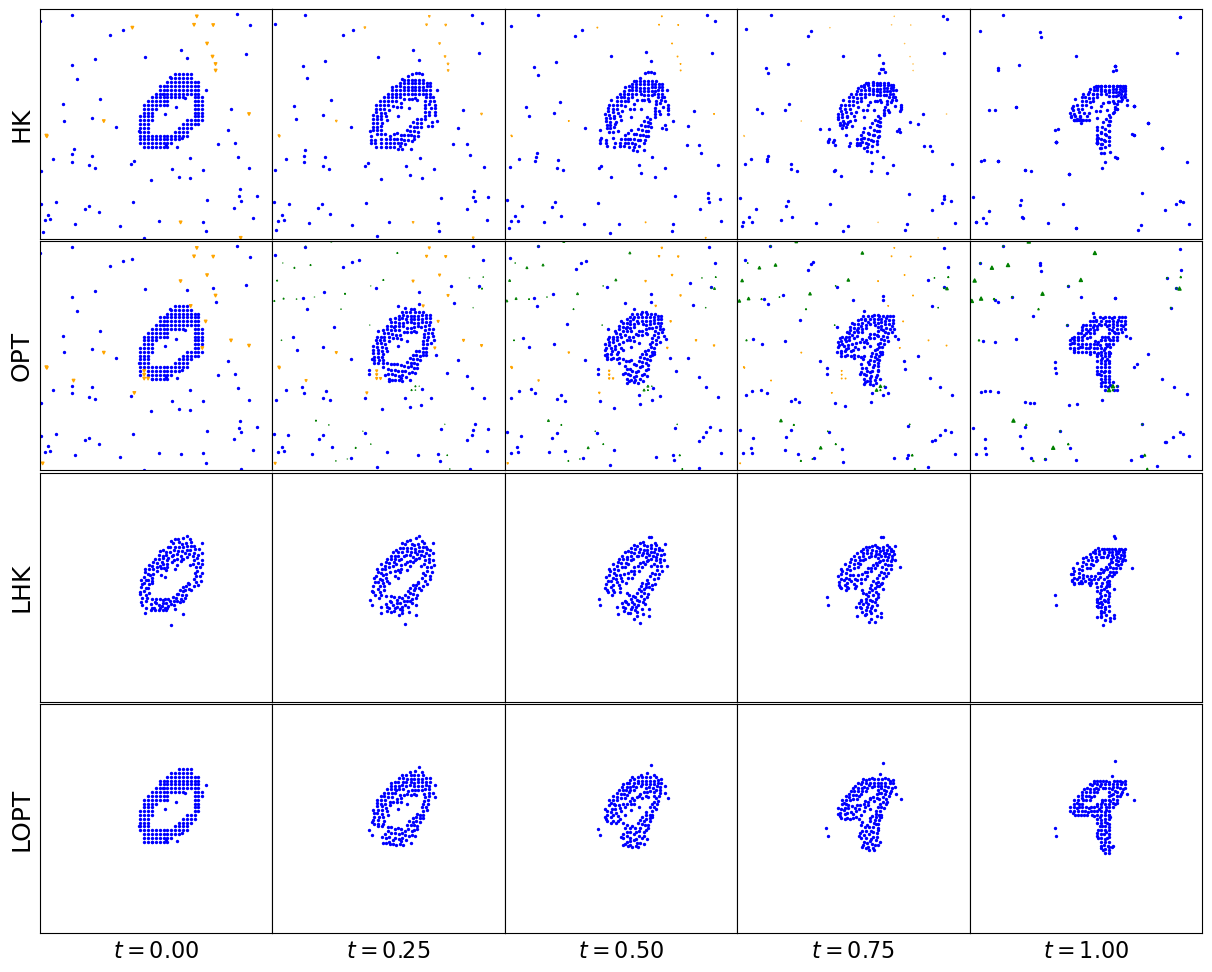

In [14]:
#label='0-9.clean.uni'

X1=Xi_list[0]
X2=Xi_list[2]
mu1=pi_list[0]
mu2=pi_list[2]
mu0=p0
s0=2
K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(4,K,figsize=(3*5,3*4))
scaling=100000
i=0  # Do HK interporlation

setup_HKScale=3.5
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=setup_HKScale
params["solver_errorGoal"]=1e-4
params["aux_verbose"]=False
params["solver_epsStart"]=1e3*setup_HKScale/1.3 
params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

value,gamma=Sinkhorn.SolveHK(mu1,X1,mu2,X2,HKScale=params["setup_HKScale"],
SinkhornError=params["solver_errorGoal"],
epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
returnSolver=False
)
u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(gamma,mu1,mu2,X2)
v0,alpha0=LinHK.HKLog(X1,u0,x1,u1,params["setup_HKScale"])
        
for j,t in enumerate(tList):
    # shoot averaged tangent vector back to a measure
    mu_a,X_a=LinHK.HKExp(mu1,X1,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
    D=np.sum(v0**2,1)>1e-10
    mu_t=mu_a[D]
    mu_d=mu_a[np.invert(D)]
    X_t=X_a[D]
    X_d=X_a[np.invert(D)]
    X_c=X2[nuPerp>0]
    mu_c=nuPerp[nuPerp>0]*t**2
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=s0,color='blue',marker='o')
        #ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    #if mu_c.shape[0]>0:
    #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
        #ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('HK',rotation=90,fontsize=18)

    
i=1 # Do OPT interporlation
Lambda=25.0
u0_opt,p0_opt,M_opt,nuPerp_opt=lopt_embedding(X1,X2,mu1,mu2,Lambda)
Xt_list,mu_t,X_d,p_d=opt_interpolation(X1,u0_opt,mu1,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
X_c=X2[nuPerp_opt>0]
p_c=nuPerp_opt[nuPerp_opt>0]
for j,t in enumerate(tList):
    X_t=Xt_list[j]
    mu_d=p_d*(1-t)
    mu_c=p_c*t
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=s0,color='blue',marker='o')
       # ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    if mu_c.shape[0]>0:
        ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
       # ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)

    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('OPT',rotation=90,fontsize=18)

        
i=2 # Do LHK interpolation 
setup_HKScale=5.0
                           
# Do HK interporlation
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=setup_HKScale
params["solver_errorGoal"]=1e-4
params["aux_verbose"]=False
params["solver_epsStart"]=1e3*setup_HKScale/1.3 
params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

value,gamma=Sinkhorn.SolveHK(mu0,X0,mu1,X1,HKScale=params["setup_HKScale"],
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False)

# from optimal coupling compute tangent vector data
u0_1,u1_1,x1_1,muPerp_1,nuPerp_1=LinHK.extractMongeData(gamma,mu0,mu1,X1)
v0_1,alpha0_1=LinHK.HKLog(X0,u0_1,x1_1,u1_1,params["setup_HKScale"])
    
    
value,gamma=Sinkhorn.SolveHK(mu0,X0,mu2,X2,HKScale=params["setup_HKScale"],
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False
        )
u0_2,u1_2,x1_2,muPerp_2,nuPerp_2=LinHK.extractMongeData(gamma,mu0,mu2,X2)
v0_2,alpha0_2=LinHK.HKLog(X0,u0_2,x1_2,u1_2,params["setup_HKScale"])

for j,t in enumerate(tList):
    # shoot averaged tangent vector back to a measure
    v0_t=(1-t)*v0_1+t*v0_2
    alpha0_t=(1-t)*alpha0_1+t*alpha0_2
    mu_a,X_a=LinHK.HKExp(p0,X0,v0_t,alpha0_t,HKScale=params["setup_HKScale"])
    D=np.sum(v0_t**2,1)>1e-10
    mu_t=mu_a[D]
    mu_d=mu_a[np.invert(D)]
    X_t=X_a[D]
    X_d=X_a[np.invert(D)]
    #X_c=X2[nuPerp>0]
    #mu_c=nuPerp[nuPerp>0]*t**2
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=s0,color='blue',marker='o')
        #ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0 and np.sum(mu_d)>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    #if mu_c.shape[0]>0:
    #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
    #    ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)
    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('LHK',rotation=90,fontsize=18)


i=3 # Do LOPT interpolation 
Lambda=30.0
u1_opt,p1_hat,M1,p1_perp=lopt_embedding(X0,X1,mu0,mu1,Lambda)
u2_opt,p2_hat,M2,p2_perp=lopt_embedding(X0,X2,mu0,mu2,Lambda)
Xt_list,mu_t,X_d,p_d,X_c,p_c=lopt_interpolation(X0,u1_opt,u2_opt,p1_hat,p2_hat,tList)   # (X0,U1,p0,p1_hat,t_list)

for j,t in enumerate(tList):
    X_t=Xt_list[j]
    mu_d=p_d*(1-t)
    mu_c=p_c*t
    if mu_t.shape[0]>0:
        ax[i,j].scatter(X_t[:,0],X_t[:,1],s=s0,color='blue',marker='o')
        #ax[i,j].scatter(X_t[:,0],X_t[:,1],s=1*scaling,color='blue',marker='o',alpha=0.1)
    if mu_d.shape[0]>0 and np.sum(mu_d)>0:
        ax[i,j].scatter(X_d[:,0],X_d[:,1],s=mu_d**2*scaling,color='orange',marker='v')
        #ax[i,j].scatter(X_d[:,0],X_d[:,1],s=1*scaling,color='orange',marker='v',alpha=0.1)
    if mu_c.shape[0]>0 and np.sum(mu_c)>0:
        ax[i,j].scatter(X_c[:,0],X_c[:,1],s=mu_c**2*scaling,color='green',marker='^')
        #ax[i,j].scatter(X_c[:,0],X_c[:,1],s=1*scaling,color='green',marker='^',alpha=0.1)

    ax[i,j].set_xlim([-20,40])
    ax[i,j].set_ylim([-20,40])
    ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if j==0:
        ax[i,j].set_ylabel('LOPT',rotation=90,fontsize=18)
                           
    
    ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)


#fig.add_artist(plt.Line2D((0, 1), (0.495,0.495), color='black', linewidth=2, transform=fig.transFigure))
plt.subplots_adjust(wspace=0, hspace=0.01)
#plt.savefig('experiment/Rebuttal/'+label+'.png',bbox_inches='tight')

plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')
